I think the CUAD dataset is ok, the only issue is that there are empty answers. We could clean the data for example.

In [1]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [2]:
from datasets import load_dataset

raw_datasets = load_dataset("cuad")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/22450 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4182 [00:00<?, ? examples/s]

In [3]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 22450
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 4182
    })
})

Now we **CLEAN the DATA**

In [4]:
from datasets import DatasetDict
# Define a filtering function
def filter_empty_answers(example):
    return example['answers']['text'] != [] and example['answers']['answer_start'] != []

# Filter out examples with empty "text" and "answer_start" fields for train split
filtered_train_dataset = raw_datasets['train'].filter(filter_empty_answers)

# Filter out examples with empty "text" and "answer_start" fields for test split
filtered_test_dataset = raw_datasets['test'].filter(filter_empty_answers)

# Create a new DatasetDict WITHOUT the filtered examples
filtered_datasets = DatasetDict({                                  # RENAME LATER TO filtered_datasets
    'train': filtered_train_dataset,
    'test': filtered_test_dataset
})

Filter:   0%|          | 0/22450 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4182 [00:00<?, ? examples/s]

In [5]:
filtered_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11180
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1244
    })
})

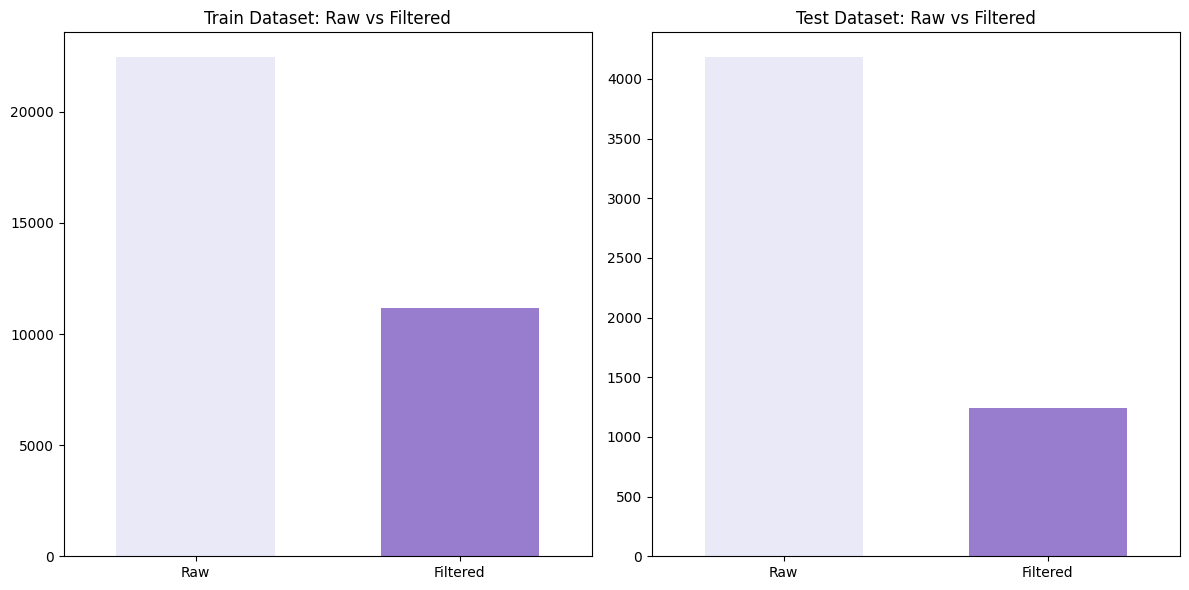

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert datasets to pandas DataFrames
raw_train_df = pd.DataFrame(raw_datasets['train'])
raw_test_df = pd.DataFrame(raw_datasets['test'])
filtered_train_df = pd.DataFrame(filtered_datasets['train'])
filtered_test_df = pd.DataFrame(filtered_datasets['test'])

# Plotting the differences between raw and filtered datasets
# For example, you can compare the number of examples in each dataset
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot number of examples in raw and filtered train datasets
sns.barplot(x=['Raw', 'Filtered'], y=[len(raw_train_df), len(filtered_train_df)], hue=['Raw', 'Filtered'], ax=axes[0], palette=['lavender', 'mediumpurple'], width=0.6, legend=False)
axes[0].set_title('Train Dataset: Raw vs Filtered')

# Plot number of examples in raw and filtered test datasets
sns.barplot(x=['Raw', 'Filtered'], y=[len(raw_test_df), len(filtered_test_df)], hue=['Raw', 'Filtered'], ax=axes[1], palette=['lavender', 'mediumpurple'], width=0.6, legend=False)
axes[1].set_title('Test Dataset: Raw vs Filtered')

plt.tight_layout()
plt.show()


In [7]:
#print("Context: ", filtered_datasets["train"][2]["context"])
print("Question: ", filtered_datasets["train"][2]["question"])
print("Answer: ", filtered_datasets["train"][2]["answers"])

Question:  Highlight the parts (if any) of this contract related to "Parties" that should be reviewed by a lawyer. Details: The two or more parties who signed the contract
Answer:  {'text': ['Electric City of Illinois L.L.C.'], 'answer_start': [49574]}


____________________


_______


The context and question fields are very straightforward to use. The answers field is a bit trickier as it comports a dictionary with two fields that are both lists.

This is the format that will be expected by the squad metric during evaluation; if you are using your own data, you don’t necessarily need to worry about putting the answers in the same format!!!!. The text field is rather obvious, and the answer_start field contains the starting character index of each answer in the context.

HERE I **CHANGED validation from test subset bc we need several possible answers**

In [8]:
from datasets import DatasetDict
import random
from datasets import load_dataset, Dataset

# Load the original dataset
#filtered_datasets = load_dataset("cuad")

# Shuffle the training dataset
filtered_datasets["train"].shuffle()

# Shuffle the test dataset
filtered_datasets["test"].shuffle()

# Select 128 random examples for training
train_indices = random.sample(range(len(filtered_datasets["train"])), 128)
train_subset = filtered_datasets["train"].select(train_indices)

#test_indices = random.sample(range(len(filtered_datasets["test"])), 128)
#test_subset = rfiltered_datasets["train"].select(train_indices)

valid_indices = random.sample(range(len(filtered_datasets["test"])), 32)
valid_subset = filtered_datasets["test"].select(valid_indices)

test_indices = random.sample(list(set(range(len(filtered_datasets["test"]))) - set(valid_indices)), 32)
test_subset = filtered_datasets["test"].select(test_indices)

# Select 32 random examples for validation
#valid_indices = random.sample(set(range(len(filtered_datasets["train"]))) - set(train_indices), 32)
#valid_subset = filtered_datasets["train"].select(valid_indices)

# Create a dictionary with the small datasets

small_cuad_dataset = {
    "train": train_subset,
    "validation": valid_subset,
    "test": test_subset
}

small_cuad_dataset

{'train': Dataset({
     features: ['id', 'title', 'context', 'question', 'answers'],
     num_rows: 128
 }),
 'validation': Dataset({
     features: ['id', 'title', 'context', 'question', 'answers'],
     num_rows: 32
 }),
 'test': Dataset({
     features: ['id', 'title', 'context', 'question', 'answers'],
     num_rows: 32
 })}

In [9]:
#print("Context: ", small_cuad_dataset["train"][0]["context"])
print("Question: ", small_cuad_dataset["train"][0]["question"])
print("Answer: ", small_cuad_dataset["train"][0]["answers"])

#print("Context: ", small_cuad_dataset["validation"][0]["context"])
print("Question: ", small_cuad_dataset["validation"][5]["question"])
print("Answer: ", small_cuad_dataset["validation"][5]["answers"])   # some have only one answer some more!!!

Question:  Highlight the parts (if any) of this contract related to "License Grant" that should be reviewed by a lawyer. Details: Does the contract contain a license granted by one party to its counterparty?
Answer:  {'text': ['Each of us grants only the licenses expressly specified herein.'], 'answer_start': [33161]}
Question:  Highlight the parts (if any) of this contract related to "Exclusivity" that should be reviewed by a lawyer. Details: Is there an exclusive dealing  commitment with the counterparty? This includes a commitment to procure all “requirements” from one party of certain technology, goods, or services or a prohibition on licensing or selling technology, goods or services to third parties, or a prohibition on  collaborating or working with other parties), whether during the contract or  after the contract ends (or both).
Answer:  {'text': ['PPI hereby grants EKR the exclusive right and license (with the right to sublicense) to use, market, promote, sell, distribute and

During training, there is only one possible answer. We can double-check this by using the **Dataset.filter() method:**

In [10]:
small_cuad_dataset["train"].filter(lambda x: len(x["answers"]["text"]) != 1)

Filter:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 0
})

For evaluation, however, there are several possible answers for each sample, which may be the same or different:

In [11]:
print(small_cuad_dataset["validation"][0]["answers"])
print(small_cuad_dataset["validation"][3]["answers"])  # some have only one answer some more!!!

{'text': ['The Professional hereby grants to the Company the exclusive and worldwide right to use her name, likeness, image and personal identification, singly or in any combination, during the Term and for a period of six (6) months after the Term as provided in Section 2.8, in the creation of two (2) print advertisements per year and one (1) television advertisement per year (together, the "Advertisements") for any golf equipment, along with all rights in any images, videos, advertisement copy or other materials created by the Professional or others.', 'The Professional agrees to serve as a spokesperson for the Company at up to two (2) Professional Golf Association merchandise shows, including but not limited to the PGA Merchandise Shows.', 'The sum of the Quarterly Grant Numbers in each calendar year of the Term shall not exceed fifteen thousand (15,000). The options will expire five (5) years after each grant date.', 'The Professional agrees to serve as a professional golf instruct

In [12]:
print(small_cuad_dataset["validation"][3]["context"])
print(small_cuad_dataset["validation"][3]["question"])

Exhibit 10.28

                              ENDORSEMENT AGREEMENT

            This Endorsement Agreement ("Agreement") is made and entered into as of August 24, 1995, by and among the following parties:

                  (a) Kathy Ireland, Inc. ("KI Inc."), furnishing the services       of Kathy Ireland ("KI"), c/o The Sterling/Winters Co., 1900 Avenue of the       Stars, Suite #1640, Los Angeles, California 90067;

                  (b) The Sterling/Winters Co. ("SW"), 1900 Avenue of the Stars,       Suite #1640, Los Angeles, California 90067; and

                  (c) Diplomat Ambassador Eyewear Group ("Diplomat"), 1010 Arch       Street, 3rd Floor, Philadelphia, Pennsylvania 19107.

            1. Recitals.

                  (a) Whereas Diplomat has created a new product line to be known as "Kathy Ireland Eyewear" ("KI Eyewear");

                  (b) Whereas Diplomat estimates on a non-binding basis that wholesale sales of KI Eyewear will reach $          during the first Lic

**CHANGED VALIDATION SUBSET!!!!!**

we can see that the answer can indeed be one of the three possibilities we saw before.

In [13]:
from transformers import RobertaTokenizerFast

model_checkpoint = "roberta-base"
tokenizer = RobertaTokenizerFast.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [14]:
tokenizer.is_fast

True

We can pass to our tokenizer the question and the context together, and it will properly insert the special tokens to form a sentence like this:

**< s> question < /s>< /s> context < /s>**

In [15]:

#print(small_cuad_dataset["train"][0]["question"])
#print(small_cuad_dataset["train"][0]["answers"])

**Achtung!**
Token indices sequence length is longer than the specified maximum sequence length for this model (8933 > 512). Running this sequence through the model will result in indexing errors

In [16]:
context = small_cuad_dataset["train"][0]["context"]
question = small_cuad_dataset["train"][0]["question"]

inputs = tokenizer(question, context)
tokenizer.decode(inputs["input_ids"])

Token indices sequence length is longer than the specified maximum sequence length for this model (9455 > 512). Running this sequence through the model will result in indexing errors


'<s>Highlight the parts (if any) of this contract related to "License Grant" that should be reviewed by a lawyer. Details: Does the contract contain a license granted by one party to its counterparty?</s></s>Exhibit 10.27\n\n                          e-business Hosting Agreement\n\n                                     between\n\n                                  Bluefly, Inc.\n\n                                       and\n\n                   International Business Machines Corporation\n\n                                        1\n\n                          e-business Hosting Agreement\n\nUnder this e-business Hosting Agreement ("Agreement") between International Business Machines Corporation ("IBM") and Bluefly, Inc. ("Customer"), IBM will provide Web hosting and related services ("Services") to Customer. The Agreement includes these terms and conditions and the documents referenced herein ("Base Terms"), e-business hosting services order forms accepted by IBM ("Order Forms"), and th

 some of the examples in the dataset have very long contexts that will exceed the maximum length we set (which is 512 in this case). As we saw in Chapter 6 when we explored the internals of the question-answering pipeline, we will deal with long contexts by creating several training features from one sample of our dataset, with a sliding window between them.

 To see how this works using the current example, we can limit the length to 100 and use a sliding window of 50 tokens. As a reminder, we use:


*   max_length to set the maximum length (here 100)
*   truncation="only_second" to truncate the context (which is in the second position) when the question with its context is too long
*   stride to set the number of overlapping tokens between two successive chunks (here 50)
*   return_overflowing_tokens=True to let the tokenizer know we want the overflowing tokens



 you can use any other model type as long as it has a fast tokenizer implemented.

In [31]:
inputs = tokenizer(
    question,
    context,
    max_length=100, # I changed from 100 to 512
    truncation="only_second", # to truncate the context (which is in the second position) when the question with its context is too long
    stride=50, # to set the number of overlapping tokens between two successive chunks (here 50)
    return_overflowing_tokens=True, # to let the tokenizer know we want the overflowing tokens
)

for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))



Streaming output truncated to the last 5000 lines.
<s>Highlight the parts (if any) of this contract related to "License Grant" that should be reviewed by a lawyer. Details: Does the contract contain a license granted by one party to its counterparty?</s></s>'s entire obligation       to Customer with regard to any claim of infringement. Notwithstanding the       foregoing, IBM is not responsible for third party claims based on:

      1.    anything Customer provides</s>
<s>Highlight the parts (if any) of this contract related to "License Grant" that should be reviewed by a lawyer. Details: Does the contract contain a license granted by one party to its counterparty?</s></s>      to Customer with regard to any claim of infringement. Notwithstanding the       foregoing, IBM is not responsible for third party claims based on:

      1.    anything Customer provides which is incorporated into</s>
<s>Highlight the parts (if any) of this contract related to "License Grant" that should be re

As we can see, our example has been in **split into X inputs**, each of them containing the question and some part of the context. (TRY CtrlF "..Highlight the parts")

 the question (“Bernadette Soubirous”) only appears in the 7th inputs, so by dealing with long contexts in this way we will create some training examples where the answer is not included in the context. For those examples, the labels will be start_position = end_position = 0 <s>(so we predict the [CLS] token).</s> We will also set those labels in the unfortunate case where the answer has been truncated so that we only have the start (or end) of it. For the examples where the answer is fully in the context, the labels will be the index of the token where the answer starts and the index of the token where the answer ends.

 The dataset provides us with the start character of the answer in the context, and by adding the length of the answer, we can find the end character in the context. To map those to token indices, we will need to use the offset mappings we studied in Chapter 6. We can have our tokenizer return these by passing along return_offsets_mapping=True:




In [33]:
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50, #50 to 100
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

As we can see, we get back the usual input IDs, token type IDs, and attention mask, as well as the offset mapping we required and an extra key, overflow_to_sample_mapping. The corresponding value will be of use to us when we tokenize several texts at the same time (which we should do to benefit from the fact that our tokenizer is backed by Rust). Since one sample can give several features, it maps each feature to the example it originated from. Because here we only tokenized one example, we get a list of 0s:

In [34]:
inputs["overflow_to_sample_mapping"] # we get 22

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


But if we tokenize more examples, this will become more useful:

In [39]:
inputs = tokenizer(
    small_cuad_dataset["train"][2:6]["question"],
    small_cuad_dataset["train"][2:6]["context"],
    max_length=100, # I changed from 100 to 512
    truncation="only_second",
    stride=39, #50 to 100
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

print(f"The 4 examples gave {len(inputs['input_ids'])} features.")
print(f"Here is where each comes from: {inputs['overflow_to_sample_mapping']}.")

The 4 examples gave 122433 features.
Here is where each comes from: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

As we can see, <s>the first three examples (at indices 2, 3, and 4 in the training set) each gave 55 features and the last example (at index 5 in the training set) gave 7 features.</s>

at indices 2 gave 99 features, at indices 3 gave 51 features, at indices 4 gave 10 features, at indices 4 gave 27 features.

This information will be useful to map each feature we get to its corresponding label. As mentioned earlier, those labels are:

*   (0, 0) if the answer is not in the corresponding span of the context
*   (start_position, end_position) if the answer is in the corresponding span of the context, with start_position being the index of the token (in the input IDs) at the start of the answer and end_position being the index of the token (in the input IDs) where the answer ends

To determine which of these is the case and, if relevant, the positions of the tokens, we first find the indices that start and end the context in the input IDs. We could use the token type IDs to do this, but since those do not necessarily exist for all models (DistilBERT does not require them, for instance), we’ll instead use the **sequence_ids()** method of the BatchEncoding our tokenizer returns.

Once we have those token indices, we look at the corresponding offsets, which are tuples of two integers representing the span of characters inside the original context. We can thus detect if the chunk of the context in this feature starts after the answer or ends before the answer begins (in which case the label is (0, 0)). If that’s not the case, we loop to find the first and last token of the answer:



**ACHTUNG!** I think the problem is that our dataset has "answers" that look like this:

{ "text": [], "answer_start": [] }

In [40]:
answers = small_cuad_dataset["train"][2:6]["answers"] #2:6 --: 1,2,4,7,8 SEE the PROBLEM down
start_positions = []
end_positions = []

for i, offset in enumerate(inputs["offset_mapping"]):
    sample_idx = inputs["overflow_to_sample_mapping"][i]
    answer = answers[sample_idx]
    start_char = answer["answer_start"][0]
    end_char = answer["answer_start"][0] + len(answer["text"][0])
    sequence_ids = inputs.sequence_ids(i)

    # Find the start and end of the context
    idx = 0
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1

    # If the answer is not fully inside the context, label is (0, 0)
    if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
        start_positions.append(0)
        end_positions.append(0)
    else:
        # Otherwise it's the start and end token positions
        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

start_positions, end_positions

([88,
  63,
  38,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

In [22]:
#print("Answer: ", small_cuad_dataset["train"][0]["answers"]) #Nothing 0, 3, 5,6,9 ok:1,2,4,7,8
print("Answer: ", small_cuad_dataset["train"][9]["answers"]) #Nothing 0, 3, 5,6,9 ok:1,2,5,6,9

Answer:  {'text': ["The Intellectual Property granted to Party B shall only be used to the scope of Party B's Business operated by Party B."], 'answer_start': [2204]}




---

In HF tutorial:

([83, 51, 19, 0, 0, 64, 27, 0, 34, 0, 0, 0, 67, 34, 0, 0, 0, 0, 0],

 [85, 53, 21, 0, 0, 70, 33, 0, 40, 0, 0, 0, 68, 35, 0, 0, 0, 0, 0])

 Let’s take a look at a few results to verify that our approach is correct. For the first feature we find (83, 85) as labels, so let’s compare the theoretical answer with the decoded span of tokens from 83 to 85 (inclusive):

 ((In our case its from 145 to 223))

In [42]:
idx = 0
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = answers[sample_idx]["text"][0]

start = start_positions[idx]
end = end_positions[idx]
labeled_answer = tokenizer.decode(inputs["input_ids"][idx][start : end + 1])

print(f"Theoretical answer: {answer}, labels give: {labeled_answer}")

Theoretical answer: SUPPLY AGREEMENT, labels give:  SUPPLY AGREEMENT


So that’s a match! Now let’s check index 4, where we set the labels to (0, 0), which means the answer is not in the context chunk of that feature:

In [43]:
idx = 4
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = answers[sample_idx]["text"][0]

decoded_example = tokenizer.decode(inputs["input_ids"][idx])
print(f"Theoretical answer: {answer}, decoded example: {decoded_example}")

Theoretical answer: SUPPLY AGREEMENT, decoded example: <s>Highlight the parts (if any) of this contract related to "Document Name" that should be reviewed by a lawyer. Details: The name of the contract</s></s> and organized and existing under the laws of Switzerland and having its registered office at Pilatusstrasse 23, CH-6003, Luzern, Switzerland (hereafter referred to as "HOVIONE"), and INTERSECT ENT, Inc. together with its subsidiaries and affiliates, and organized and existing under the</s>


Indeed, we don’t see the answer inside the context.

Now that we have seen step by step how to preprocess our training data, we can group it in a function we will apply on the whole training dataset. We’ll pad every feature to the maximum length we set, as most of the contexts will be long (and the corresponding samples will be split into several features), so there is no real benefit to applying dynamic padding here:

In [45]:
max_length = 512
stride = 128


def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

Note that we defined two constants to determine the maximum length used as well as the length of the sliding window, and that we added a tiny bit of cleanup before tokenizing: some of the questions in the SQuAD dataset have extra spaces at the beginning and the end that don’t add anything (and take up space when being tokenized if you use a model like RoBERTa), so we removed those extra spaces.

To apply this function to the whole training set, we use the **Dataset.map()** method with the batched=True flag. It’s necessary here as we are changing the length of the dataset (since one example can give several training features):

In [46]:
train_dataset = small_cuad_dataset["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=small_cuad_dataset["train"].column_names,
)
len(small_cuad_dataset["train"]), len(train_dataset)

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

(128, 7138)

As we can see, the preprocessing added roughly <s>1,000</s> 8569 features. Our training set is now ready to be used — let’s dig into the preprocessing of the validation set!

**Processing the validation data**

Preprocessing the validation data will be slightly easier as we don’t need to generate labels (unless we want to compute a validation loss, but that number won’t really help us understand how good the model is). The real joy will be to interpret the predictions of the model into spans of the original context. For this, we will just need to store both the offset mappings and some way to match each created feature to the original example it comes from. Since there is an ID column in the original dataset, we’ll use that ID.

The only thing we’ll add here is a tiny bit of cleanup of the offset mappings. They will contain offsets for the question and the context, but once we’re in the post-processing stage we won’t have any way to know which part of the input IDs corresponded to the context and which part was the question (the **sequence_ids() **method we used is available for the output of the tokenizer only). So, we’ll set the offsets corresponding to the question to None:

In [47]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

We can apply this function on the whole validation dataset like before:

In [48]:
validation_dataset = small_cuad_dataset["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=small_cuad_dataset["validation"].column_names,
)
len(small_cuad_dataset["validation"]), len(validation_dataset)

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

(32, 1430)

<s>In this case we’ve only added a couple of hundred samples, so it appears the contexts in the validation dataset are a bit shorter.

Now that we have preprocessed all the data, we can get to the training.

# **Fine-tuning the model with the Trainer API**

The training code for this example will look a lot like the code in the previous sections — the hardest thing will be to write the compute_metrics() function. Since we padded all the samples to the maximum length we set, there is no data collator to define, so this metric computation is really the only thing we have to worry about. The difficult part will be to post-process the model predictions into spans of text in the original examples; once we have done that, the metric from the 🤗 Datasets library will do most of the work for us.

The model will output logits for the start and end positions of the answer in the input IDs, as we saw during our exploration of the question-answering pipeline. The post-processing step will be similar to what we did there, so here’s a quick reminder of the actions we took:

* We masked the start and end logits corresponding to tokens outside of the context.
* We then converted the start and end logits into probabilities using a softmax.
* We attributed a score to each (start_token, end_token) pair by taking the product of the corresponding two probabilities.
* We looked for the pair with the maximum score that yielded a valid answer (e.g., a start_token lower than end_token).

Here we will change this process slightly because we don’t need to compute actual scores (just the predicted answer). This means we can skip the softmax step. To go faster, we also won’t score all the possible (start_token, end_token) pairs, but only the ones corresponding to the highest n_best logits (with n_best=20). Since we will skip the softmax, those scores will be logit scores, and will be obtained by taking the sum of the start and end logits (instead of the product, because of the rule

log(ab)=log(a)+log(b)).

To demonstrate all of this, we will need some kind of predictions. Since we have not trained our model yet, we are going to use the default model for the QA pipeline to generate some predictions on a small part of the validation set. We can use the same processing function as before; because it relies on the global constant tokenizer, we just have to change that object to the tokenizer of the model we want to use temporarily:

In [55]:
small_eval_set = small_cuad_dataset["validation"].select(range(32))
trained_checkpoint = "roberta-base"

tokenizer = RobertaTokenizerFast.from_pretrained(trained_checkpoint)
eval_set = small_eval_set.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=small_cuad_dataset["validation"].column_names,
)

Now that the preprocessing is done, we change the tokenizer back to the one we originally picked:

In [56]:
tokenizer = RobertaTokenizerFast.from_pretrained(model_checkpoint)

We then remove the columns of our eval_set that are not expected by the model, build a batch with all of that small validation set, and pass it through the model. If a GPU is available, we use it to go faster:

# **HERE COMES THE ISSUE **

In [ ]:
import torch
from transformers import AutoModelForQuestionAnswering

eval_set_for_model = eval_set.remove_columns(["example_id", "offset_mapping"])
eval_set_for_model.set_format("torch")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch = {k: eval_set_for_model[k].to(device) for k in eval_set_for_model.column_names}
trained_model = AutoModelForQuestionAnswering.from_pretrained(trained_checkpoint).to(
    device
)

with torch.no_grad():
    outputs = trained_model(**batch)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Since the Trainer will give us predictions as NumPy arrays, we grab the start and end logits and convert them to that format:

In [ ]:
start_logits = outputs.start_logits.cpu().numpy()
end_logits = outputs.end_logits.cpu().numpy()